# LSOAs & IMD 2019 Data

Importing Packages

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [3]:
mms  = MinMaxScaler(feature_range=(0,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

In [4]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [17]:
imd2019_all = pd.read_excel('IMD2019.xlsx', sheet_name = 'IMD 2019')

In [19]:
imd2019_all.head(5)

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Score,Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Score,Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,6.21,29199,9,0.01,32831,10,...,10,-2.01,32662,10,29.47,7319,3,31.87,7789,3
1,E01000002,City of London 001B,E09000001,City of London,5.14,30379,10,0.03,29901,10,...,10,-2.34,32789,10,24.41,11707,4,23.08,13070,4
2,E01000003,City of London 001C,E09000001,City of London,19.40,14915,5,0.09,18510,6,...,6,-1.03,29363,9,40.10,2157,1,40.53,4092,2
3,E01000005,City of London 001E,E09000001,City of London,28.65,8678,3,0.21,6029,2,...,6,-1.32,31059,10,39.90,2217,1,28.98,9397,3
4,E01032739,City of London 001F,E09000001,City of London,13.58,20391,7,0.01,32638,10,...,8,-1.56,31947,10,46.31,837,1,49.16,2040,1


In [20]:
imd2019_all.columns.tolist()

['LSOA code (2011)',
 'LSOA name (2011)',
 'Local Authority District code (2019)',
 'Local Authority District name (2019)',
 'Index of Multiple Deprivation (IMD) Score',
 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
 'Income Score (rate)',
 'Income Rank (where 1 is most deprived)',
 'Income Decile (where 1 is most deprived 10% of LSOAs)',
 'Employment Score (rate)',
 'Employment Rank (where 1 is most deprived)',
 'Employment Decile (where 1 is most deprived 10% of LSOAs)',
 'Education, Skills and Training Score',
 'Education, Skills and Training Rank (where 1 is most deprived)',
 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
 'Health Deprivation and Disability Score',
 'Health Deprivation and Disability Rank (where 1 is most deprived)',
 'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
 'Crime Score',
 'Cr

In [23]:
to_drop = ['Income Score (rate)',
 'Income Rank (where 1 is most deprived)',
 'Income Decile (where 1 is most deprived 10% of LSOAs)',
 'Employment Score (rate)',
 'Employment Rank (where 1 is most deprived)',
 'Employment Decile (where 1 is most deprived 10% of LSOAs)',
 'Education, Skills and Training Score',
 'Education, Skills and Training Rank (where 1 is most deprived)',
 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
 'Health Deprivation and Disability Score',
 'Health Deprivation and Disability Rank (where 1 is most deprived)',
 'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
 'Crime Score',
 'Crime Rank (where 1 is most deprived)',
 'Crime Decile (where 1 is most deprived 10% of LSOAs)']

imd2019_clean = imd2019_all.drop(axis=1, columns=to_drop)

In [24]:
imd2019_clean

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Score,Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,6.21,29199,9,29.47,7319,3,31.87,7789,3
1,E01000002,City of London 001B,E09000001,City of London,5.14,30379,10,24.41,11707,4,23.08,13070,4
2,E01000003,City of London 001C,E09000001,City of London,19.40,14915,5,40.10,2157,1,40.53,4092,2
3,E01000005,City of London 001E,E09000001,City of London,28.65,8678,3,39.90,2217,1,28.98,9397,3
4,E01032739,City of London 001F,E09000001,City of London,13.58,20391,7,46.31,837,1,49.16,2040,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033604,Westminster 009J,E09000033,Westminster,33.47,6478,2,27.77,8637,3,45.53,2782,1
4831,E01033605,Westminster 009K,E09000033,Westminster,40.54,4098,2,25.35,10791,4,34.15,6610,3
4832,E01033606,Westminster 014F,E09000033,Westminster,14.01,19938,7,25.42,10720,4,34.48,6478,2
4833,E01033607,Westminster 014G,E09000033,Westminster,22.19,12626,4,23.50,12671,4,43.71,3235,1


In [25]:
imd2019_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 13 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   LSOA code (2011)                                                                    4835 non-null   object 
 1   LSOA name (2011)                                                                    4835 non-null   object 
 2   Local Authority District code (2019)                                                4835 non-null   object 
 3   Local Authority District name (2019)                                                4835 non-null   object 
 4   Index of Multiple Deprivation (IMD) Score                                           4835 non-null   float64
 5   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)                 4835 non-null

In [56]:
to_drop2 = ['LSOA name (2011)',
 'Index of Multiple Deprivation (IMD) Score',
 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
 'Living Environment Score',
 'Living Environment Rank (where 1 is most deprived)',
 'Living Environment Decile (where 1 is most deprived 10% of LSOAs)']

In [57]:
imd2019_housing = imd2019_clean.drop(axis=1, columns=to_drop2)

In [58]:
imd2019_housing.head(10)

,LSOA code (2011),Local Authority District code (2019),Local Authority District name (2019),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,E09000001,City of London,29.47,7319,3
1,E01000002,E09000001,City of London,24.41,11707,4
2,E01000003,E09000001,City of London,40.10,2157,1
3,E01000005,E09000001,City of London,39.90,2217,1
4,E01032739,E09000001,City of London,46.31,837,1
5,E01032740,E09000001,City of London,37.43,3054,1
6,E01000006,E09000002,Barking and Dagenham,45.17,1033,1
7,E01000007,E09000002,Barking and Dagenham,50.42,274,1
8,E01000008,E09000002,Barking and Dagenham,45.41,981,1
9,E01000009,E09000002,Barking and Dagenham,48.12,554,1


In [135]:
shp_file = gpd.read_file('ESRI/LSOA_2011_London_gen_MHW.shp')

In [84]:
shp_file.head(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.90,876,1.70,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.90,830,1.70,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.70,817,1.50,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.00,467,2.10,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.20,543,3.10,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [76]:
# imd2019_house_geom = pd.merge(shp_file, imd2019_housing, how="left", left_on='GSS_CODE', right_on='LSOA code (2011)')

In [82]:
imd2019_housing

,LSOA code (2011),Local Authority District code (2019),Local Authority District name (2019),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,E09000001,City of London,29.47,7319,3
1,E01000002,E09000001,City of London,24.41,11707,4
2,E01000003,E09000001,City of London,40.10,2157,1
3,E01000005,E09000001,City of London,39.90,2217,1
4,E01032739,E09000001,City of London,46.31,837,1
...,...,...,...,...,...,...
4830,E01033604,E09000033,Westminster,27.77,8637,3
4831,E01033605,E09000033,Westminster,25.35,10791,4
4832,E01033606,E09000033,Westminster,25.42,10720,4
4833,E01033607,E09000033,Westminster,23.50,12671,4


In [85]:
imd2019_house_geom = shp_file.merge(imd2019_housing, how="right", left_on='LSOA11CD', right_on='LSOA code (2011)')

In [91]:
imd2019_house_geom = imd2019_house_geom.rename(columns= {'Local Authority District name (2019)':'LAD'})

In [104]:
mms.fit(imd2019_house_geom[["Barriers to Housing and Services Score"]])
imd2019_house_geom["transformed_mms"] = mms.transform(imd2019_house_geom[["Barriers to Housing and Services Score"]])

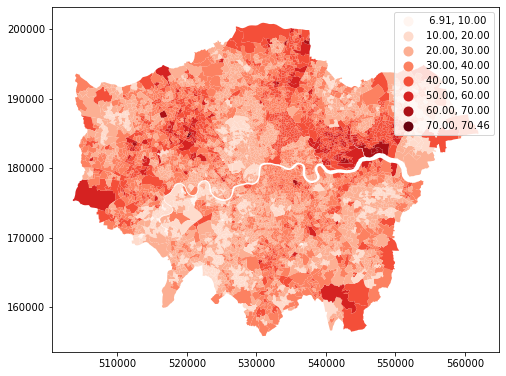

In [120]:
imd2019_house_geom = imd2019_house_geom.set_geometry('geometry')
imd2019_house_geom.plot(column='Barriers to Housing and Services Score', scheme='user_defined', classification_kwds={'bins':[10,20,30,40,50,60,70]}, legend=True, figsize=(8,8), cmap = 'Reds');

In [99]:
kc = imd2019_house_geom[imd2019_house_geom.LAD.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} LSOAs in the cleaned geodataset for Kensington and Chelsea")
Camden = imd2019_house_geom[imd2019_house_geom.LAD.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} LSOAs in the cleaned geodataset for Camden")
th = imd2019_house_geom[imd2019_house_geom.LAD.str.contains(r'Tower Hamlets', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {th.shape[0]:,} LSOAs in the cleaned geodataset for Tower Hamlets")

Found 103 LSOAs in the cleaned geodataset for Kensington and Chelsea
Found 133 LSOAs in the cleaned geodataset for Camden
Found 144 LSOAs in the cleaned geodataset for Tower Hamlets


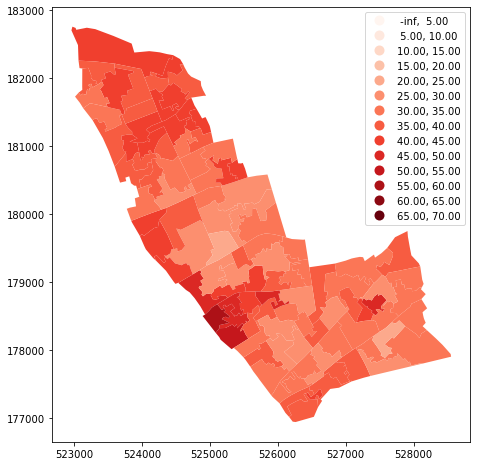

In [126]:
kcg = kc.set_geometry('geometry')
kcg.plot(column='Barriers to Housing and Services Score', legend=True, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[5,10,15,20,25,30,35,40,45,50,55,60,65,70]},cmap = 'Reds');

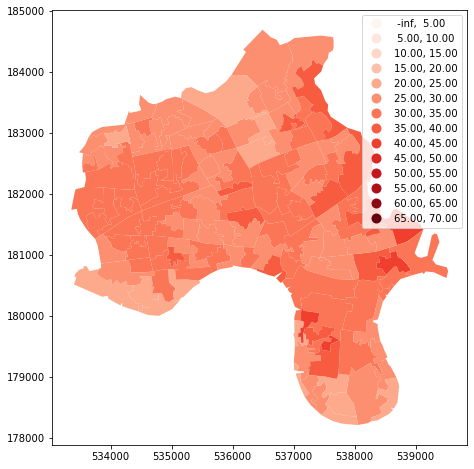

In [125]:
thg = th.set_geometry('geometry')
thg.plot(column='Barriers to Housing and Services Score', legend=True, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[5,10,15,20,25,30,35,40,45,50,55,60,65,70]},cmap = 'Reds');

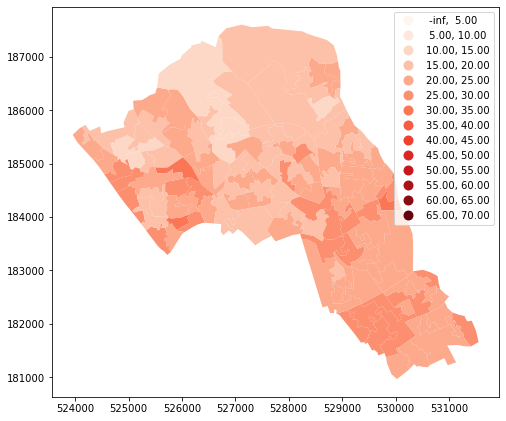

In [127]:
Camdeng = Camden.set_geometry('geometry')
Camdeng.plot(column='Barriers to Housing and Services Score', legend=True, figsize=(8,8), scheme='user_defined', classification_kwds={'bins':[5,10,15,20,25,30,35,40,45,50,55,60,65,70]},cmap = 'Reds');

In [129]:
kc['Barriers to Housing and Services Score'].describe()

count   103.00
mean     36.07
std       6.19
min      24.35
25%      31.74
50%      35.51
75%      40.41
max      56.66
Name: Barriers to Housing and Services Score, dtype: float64

In [130]:
th['Barriers to Housing and Services Score'].describe()

count   144.00
mean     30.32
std       4.10
min      21.03
25%      27.66
50%      30.10
75%      32.79
max      43.59
Name: Barriers to Housing and Services Score, dtype: float64

In [131]:
Camden['Barriers to Housing and Services Score'].describe()

count   133.00
mean     21.55
std       4.09
min      11.87
25%      18.66
50%      21.75
75%      24.27
max      31.83
Name: Barriers to Housing and Services Score, dtype: float64

In [132]:
Hackney = imd2019_house_geom[imd2019_house_geom.LAD.str.contains(r'Hackney', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Hackney.shape[0]:,} LSOAs in the cleaned geodataset for Tower Hamlets")

Found 144 LSOAs in the cleaned geodataset for Tower Hamlets


In [133]:
Hackney['Barriers to Housing and Services Score'].describe()

count   144.00
mean     42.66
std       3.38
min      30.13
25%      40.80
50%      42.59
75%      44.88
max      51.04
Name: Barriers to Housing and Services Score, dtype: float64

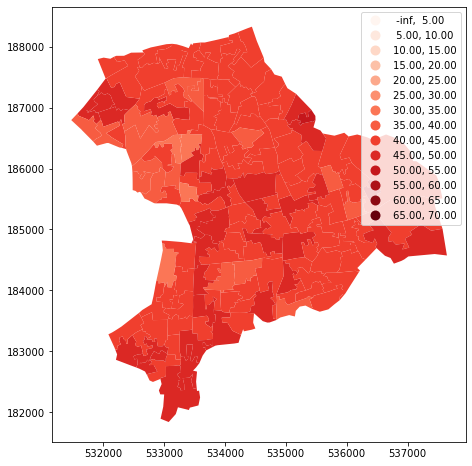

In [134]:
Hackg = Hackney.set_geometry('geometry')
Hackg.plot(column='Barriers to Housing and Services Score', legend=True, figsize=(8,8), scheme='user_defined', classification_kwds={'bins':[5,10,15,20,25,30,35,40,45,50,55,60,65,70]},cmap = 'Reds');